In [1]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os
import pathlib

os.getcwd()

#数据加载-------------------------------------
df = pd.read_csv(pathlib.Path.cwd() / ".." / "data"/ "testCSI300.csv")  # 绝对路径
df.index=pd.to_datetime(df.date)

#构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params=()

    def log(self,txt,dt=None):
        dt= dt or self.datetime.date(0)
        print('%s,%s' % (dt.isoformat(),txt)) 

    def __init__(self):
        self.bar_num=0
        self.signal_df=df
        self.signal_df['date']=pd.to_datetime(self.signal_df['date'])
        self.first_trade=True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num+=1
        current_date=self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date =self.datas[0].datetime.date(1)
        except:
            next_date=None
        if next_date != None:
            next_signal_df= self.signal_df[self.signal_df['date']==pd.to_datetime(next_date)]
            if len(next_signal_df)==0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])
                
                #第一次交易没有底仓，只允许做多
                #交易信号的执行方式：
                #先不考虑卖空
                #signal为1，以当天开盘价全仓买入
                #signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal==-1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size,price=open_price)
                        self.first_trade=False
                else:
                    #现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size=total_value//open_price
                        self.buy(self.datas[0],size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        # target_size=total_value//open_price
                        # #卖出开仓，手数不能超过底仓
                        # if target_size>now_hold_size:
                        #     target_size=now_hold_size
                        self.sell(self.datas[0],size=now_hold_size, price=open_price)

    #订单情况
    def notify_order(self, order):
        
        #订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        #订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)
        
        elif order.status in [order.Canceled,order.Rejected,order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    #交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
            % (trade.pnl, trade.pnlcomm, trade.commission))
        


cerebro=bt.Cerebro()

stock_df=df[['open','high','low','close','volume']]


In [2]:
#日期要对应，fromdate和todate要改
data=bt.feeds.PandasData(dataname=stock_df,fromdate=dt.datetime(2014, 3, 7), todate=dt.datetime(2021, 12, 30),timeframe=bt.TimeFrame.Days)

cerebro.adddata(data)

#滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)
#初始资金设置为10万
cerebro.broker.setcash(100000.0)
#手续费万分之二
cerebro.broker.setcommission(commission=0.0002)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio,_name='PyFolio')

#运行回测
print('start portfolio value:',format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:',format(cerebro.broker.getvalue()))


#绩效评价----------------------------
#获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
#以下returns为以日期为索引的资产日收益率序列
returns,positions,transactions,gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 100000.0
2016-03-24,买单执行,3211.50
2016-03-29,卖单执行,3171.310000
毛收益 -1245.89, 扣佣后收益 -1285.46 , 佣金 39.57
2016-05-06,买单执行,3213.14
2016-05-09,卖单执行,3115.430000
毛收益 -2931.30, 扣佣后收益 -2969.27 , 佣金 37.97
2016-06-02,买单执行,3158.03
2016-06-14,卖单执行,3058.440000
毛收益 -2987.70, 扣佣后收益 -3025.00 , 佣金 37.30
2016-07-06,买单执行,3197.62
2016-07-21,卖单执行,3238.340000
毛收益 1140.16, 扣佣后收益  1104.12 , 佣金 36.04
2016-08-11,买单执行,3239.56
2016-08-24,卖单执行,3341.930000
毛收益 2866.36, 扣佣后收益  2829.50 , 佣金 36.86
2016-10-13,买单执行,3299.16
2016-11-01,卖单执行,3338.710000
毛收益 1146.95, 扣佣后收益  1108.45 , 佣金 38.50
2016-11-02,买单执行,3350.71
2016-11-03,卖单执行,3326.900000
毛收益 -690.49, 扣佣后收益 -729.22 , 佣金 38.73
2016-11-09,买单执行,3370.60
2016-12-06,卖单执行,3466.240000
毛收益 2677.92, 扣佣后收益  2639.63 , 佣金 38.29
2017-01-06,买单执行,3366.85
2017-01-13,卖单执行,3317.960000
毛收益 -1417.81, 扣佣后收益 -1456.58 , 佣金 38.77
2017-01-26,买单执行,3378.26
2017-02-28,卖单执行,3445.030000
毛收益 1936.33, 扣佣后收益  1896.75 , 佣金 39.58
2017-04-10,买单执行,3519.46
2017-04-17,卖单执行,3475.740000
毛收益

                    Strategy
------------------  ----------
Start Period        2016-03-23
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      41.0%

Cumulative Return   33.45%
CAGR﹪              5.12%

Sharpe              0.57
Sortino             0.89
Sortino/√2          0.63
Omega               1.17

Max Drawdown        -14.88%
Longest DD Days     534

Gain/Pain Ratio     0.17
Gain/Pain (1M)      0.62

Payoff Ratio        1.22
Profit Factor       1.17
Common Sense Ratio  1.34
CPC Index           0.7
Tail Ratio          1.14
Outlier Win Ratio   11.04
Outlier Loss Ratio  2.85

MTD                 -0.03%
3M                  -0.03%
6M                  -4.74%
YTD                 -4.41%
1Y                  -1.31%
3Y (ann.)           9.74%
5Y (ann.)           6.02%
10Y (ann.)          5.12%
All-time (ann.)     5.12%

Avg. Drawdown       -2.95%
Avg. Drawdown Days  78
Recovery Factor     2.25
Ulcer Index         0.06
Serenity Index      0.31


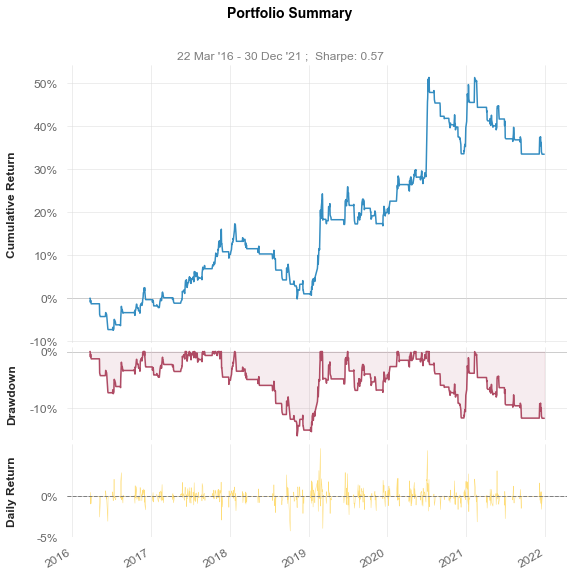

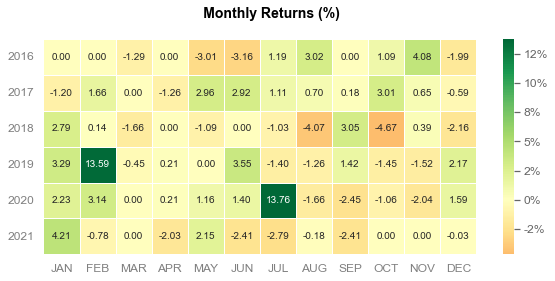

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2016-03-23  2016-03-23
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             41.0%       100.0%

Cumulative Return          33.45%      52.08%
CAGR﹪                     5.12%       7.53%

Sharpe                     0.57        0.5
Smart Sharpe               0.52        0.46
Sortino                    0.89        0.7
Smart Sortino              0.82        0.65
Sortino/√2                 0.63        0.5
Smart Sortino/√2           0.58        0.46
Omega                      1.17        1.17

Max Drawdown               -14.88%     -32.46%
Longest DD Days            534         890
Volatility (ann.)          9.97%       18.46%
R^2                        0.3         0.3
Calmar                     0.34        0.23
Skew                       1.08        -0.34
Kurtosis                   17.12       3.97


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-01-25,2018-11-09,2019-02-25,396,-14.879166,-13.882732
2,2020-07-14,2021-12-20,2021-12-30,534,-11.783814,-11.758578
3,2016-03-24,2016-07-08,2016-11-24,245,-7.447160,-7.137760
4,2019-07-03,2019-12-12,2020-02-17,229,-7.203860,-6.858348
5,2017-11-23,2017-12-27,2018-01-23,61,-5.795232,-5.150893


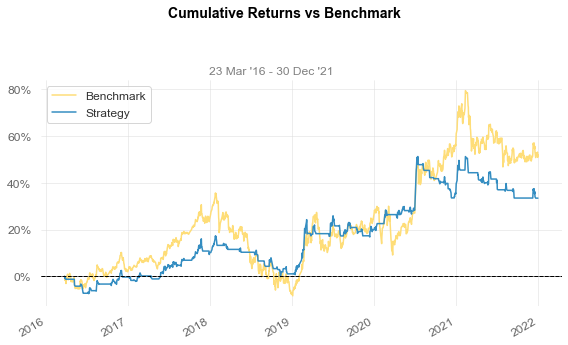

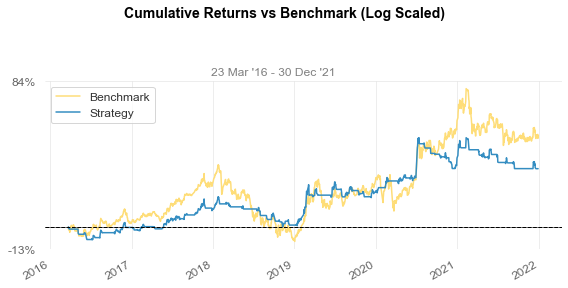

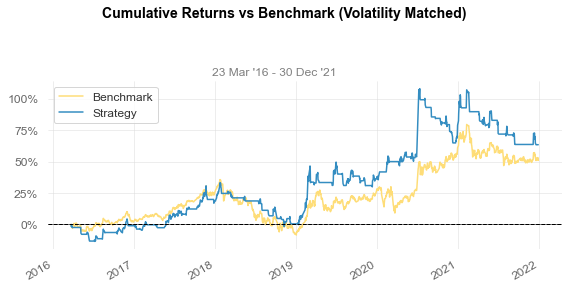

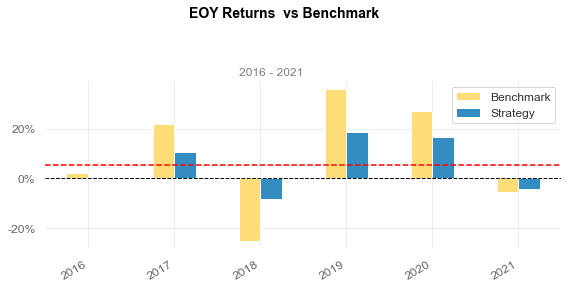

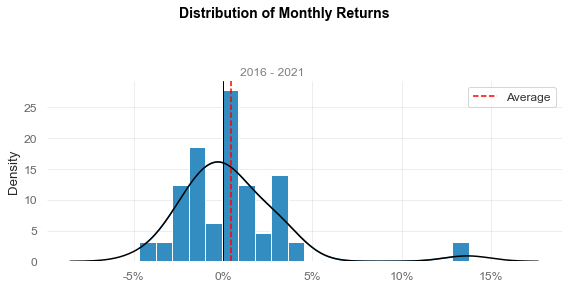

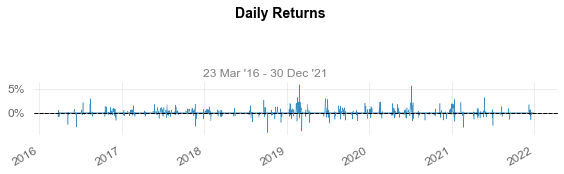

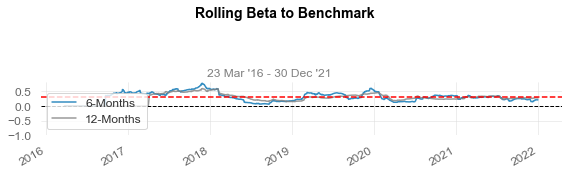

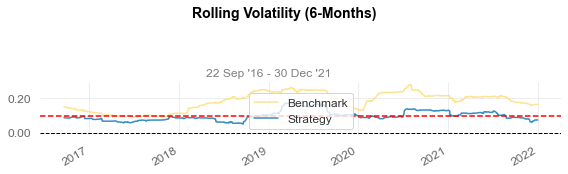

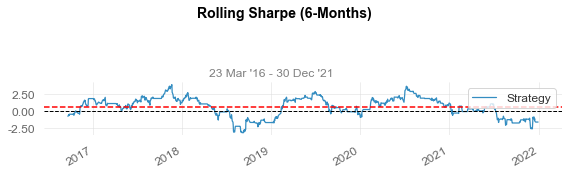

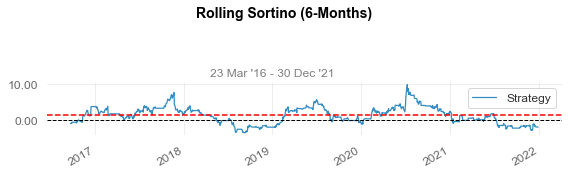

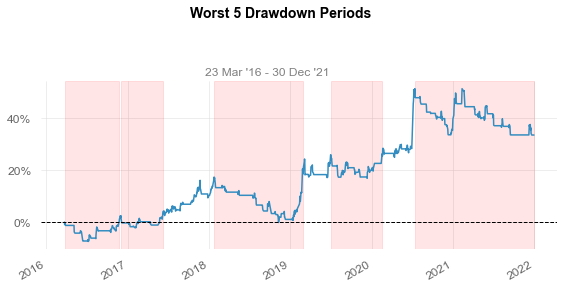

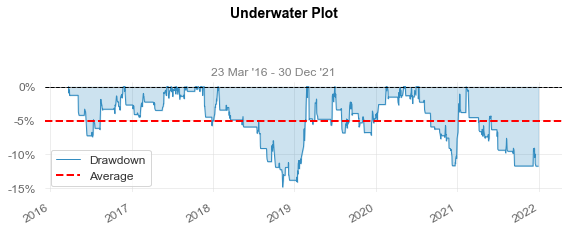

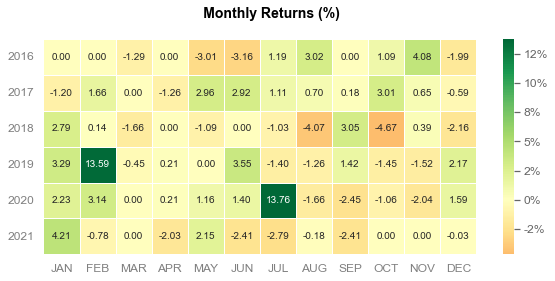

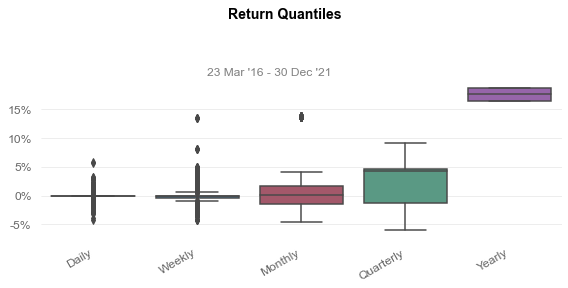

In [3]:
#画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns,rf=0.00,grayscale=False,display=True,compounded = True)
#只有在full中有和benchmark的对比
qs.reports.full(returns,benchmark=stock_df['close'],rf=0.00,grayscale=False,display=True,compounded = True)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2016-03-23  2016-03-23
End Period          2021-12-30  2021-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      95.0%       100.0%

Cumulative Return   68.24%      52.57%
CAGR﹪              9.43%       7.59%

Sharpe              0.84        0.5
Sortino             1.23        0.71
Sortino/√2          0.87        0.5
Omega               1.18        1.18

Max Drawdown        -10.84%     -32.46%
Longest DD Days     459         890

Gain/Pain Ratio     0.18        0.09
Gain/Pain (1M)      1.05        0.56

Payoff Ratio        0.89        1.02
Profit Factor       1.18        1.09
Common Sense Ratio  1.37        1.17
CPC Index           0.61        0.59
Tail Ratio          1.16        1.07
Outlier Win Ratio   5.89        3.07
Outlier Loss Ratio  4.8         3.23

MTD                 -2.61%      1.85%
3M                  -1.14%      0.77%
6M                  -0.92%      -5.18%


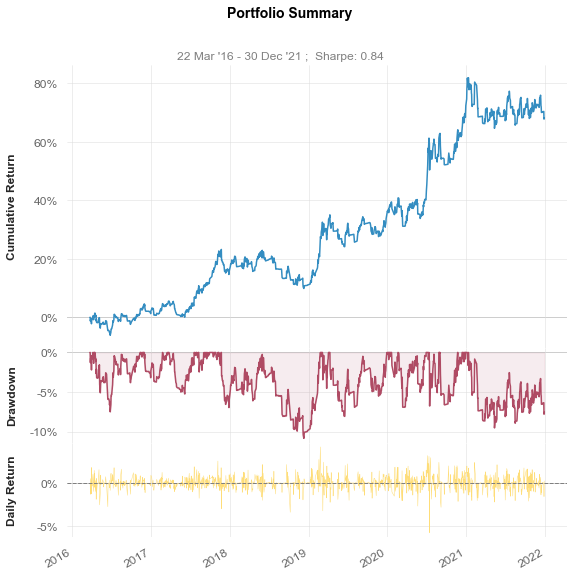

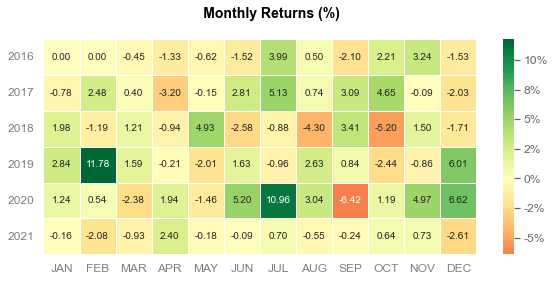

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2016-03-23  2016-03-23
End Period                 2021-12-30  2021-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             95.0%       100.0%

Cumulative Return          68.24%      52.57%
CAGR﹪                     9.43%       7.59%

Sharpe                     0.84        0.5
Smart Sharpe               0.84        0.5
Sortino                    1.23        0.71
Smart Sortino              1.22        0.7
Sortino/√2                 0.87        0.5
Smart Sortino/√2           0.86        0.5
Omega                      1.18        1.18

Max Drawdown               -10.84%     -32.46%
Longest DD Days            459         890
Volatility (ann.)          11.89%      18.46%
R^2                        0.42        0.42
Calmar                     0.87        0.23
Skew                       -0.22       -0.34
Kurtosis                   5.21        3.97



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-11-23,2018-12-10,2019-02-25,459,-10.838354,-10.072718
2,2021-01-13,2021-05-13,2021-12-30,351,-9.518802,-8.788613
3,2019-04-11,2019-06-17,2019-12-31,264,-8.072107,-7.981552
4,2016-04-15,2016-06-24,2016-11-10,209,-7.490578,-6.631070
5,2020-02-24,2020-03-13,2020-06-30,127,-6.907344,-6.855934


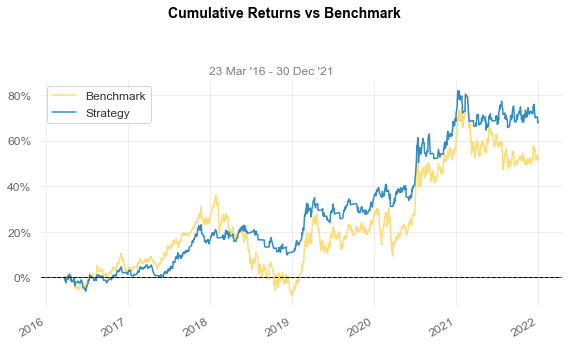

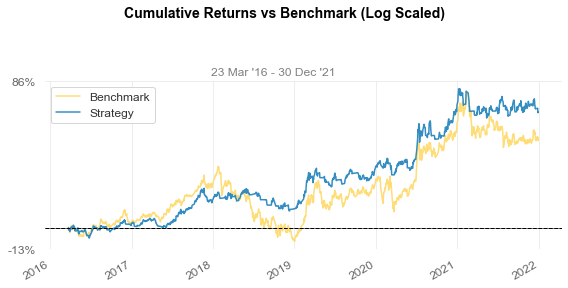

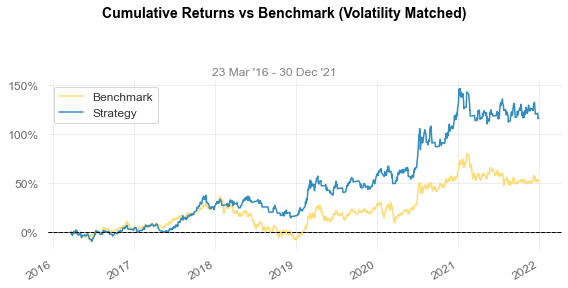

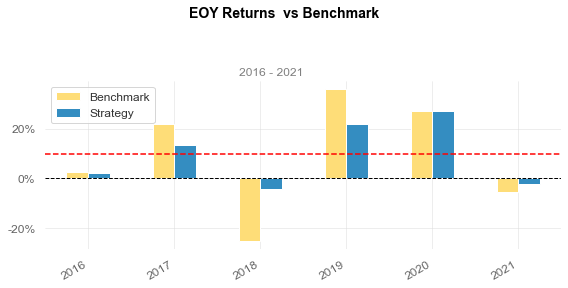

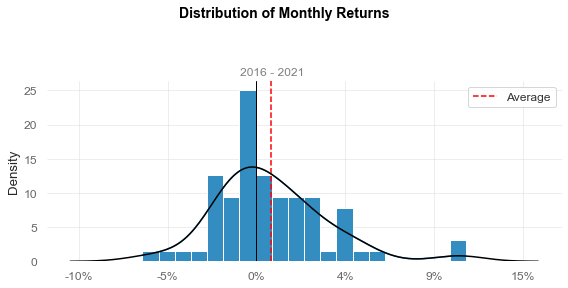

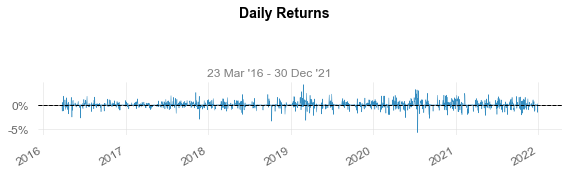

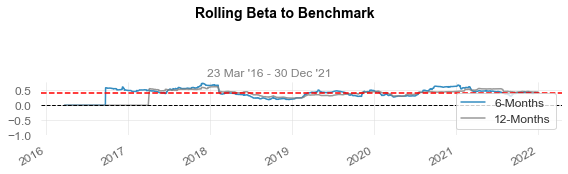

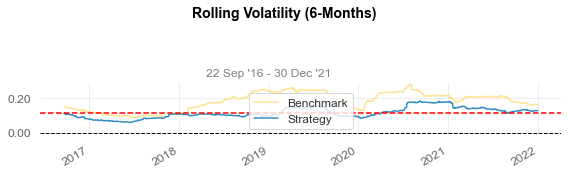

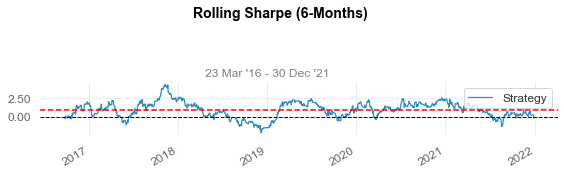

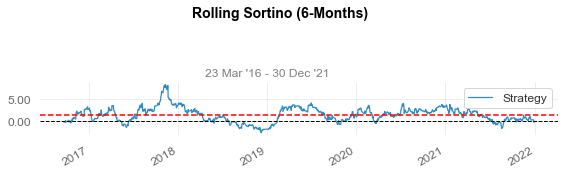

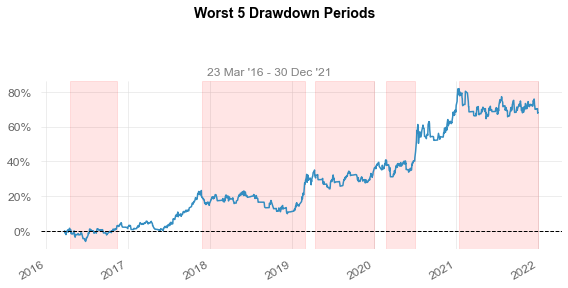

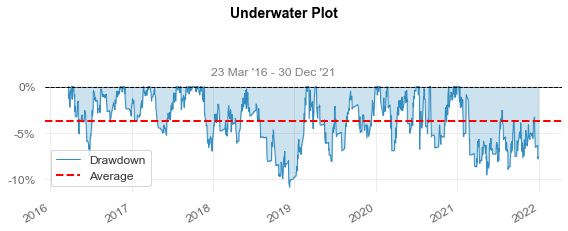

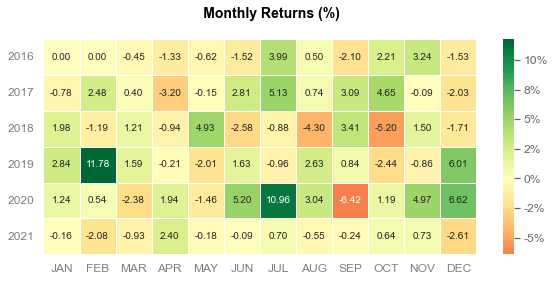

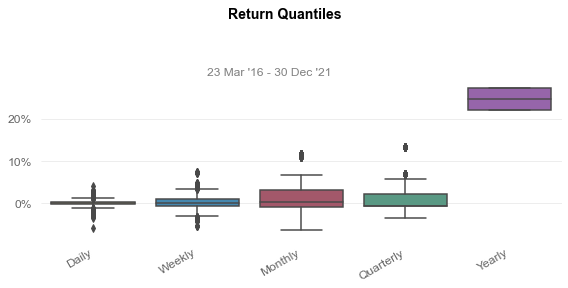

In [12]:
import numpy as np
import pandas as pd

import pathlib
from matplotlib import pyplot as plt

# %matplotlib inline
import quantstats as qs


def simple_test(dataset1, dataset2):
    ret = []
    cumulative_ret = [1]
    period_length = dataset1.shape[0]

    for i in range(period_length):
        signal = np.array(dataset1.iloc[i, :])
        signal = (signal + 1) / 2
        rate = np.array(dataset2.iloc[i, :])
        position_sum = np.sum(signal) + 1e-9
        w = signal / position_sum
        r = np.dot(w.T, rate)
        ret.append(r)
        cumulative_ret.append(cumulative_ret[-1] * (1 + r))

    return cumulative_ret


indexList = ['CSI300', 'CSI905', 'CSI012', 'CSI033', 'CSI036', 'CSI037']

df_data_path = pathlib.Path.cwd() / ".." / "data"

dataset1 = pd.DataFrame()
dataset2 = pd.DataFrame()
# print(dataset1)
for index in indexList:
    dataset = pd.read_csv(df_data_path / ('test' + index + '.csv'), header=0,
                          index_col="date", parse_dates=True)
    # print(dataset.shape)
    # dataset1 = dataset1.append(dataset['signal'])
    dataset1 = pd.merge(dataset1, dataset['signal'], how='outer',
                        left_index=True, right_index=True, suffixes=('', index))
    dataset2 = pd.merge(dataset2, dataset['return'], how='outer',
                        left_index=True, right_index=True, suffixes=('', index))


# print(dataset1)
# print(dataset2)

cumulative_ret = simple_test(dataset1, dataset2)

dataset1['return'] = cumulative_ret[1:]

# print(cumulative_ret)
# plt.plot(cumulative_ret)

# plt.figure()
qs.reports.basic(dataset1['return'], benchmark=dataset2['return'], rf=0.00,
                 grayscale=False, figsize=(8, 5), display=True, compounded=True)
# basic(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=False)
qs.reports.full(dataset1['return'], benchmark=dataset2['return'], rf=0.00,
                grayscale=False, figsize=(8, 5), display=True, compounded=True)
# plt.show()